In [3]:
using PyPlot
using Optim
using LineSearches

include("studentt.jl");  
include("mrf_prior.jl");
include("problem1.jl");  ## for using gradient of posterior functions already implemented for problem1


function grad_loss(gt::Array{Float64,2}, X::Array{Float64,2})
    
    ms = (gt-X).^2 #mean square err
  
    mss = sum(ms)#/(size(gt,1)*size(gt,2));
   
    d = gt-X;
    G=-20*(1/(log(10)*mss))*(d);
  
   
return G::Array{Float64,2}
end

function prediction(X::Array{Float64,2}, Y::Array{Float64,2}, sigma_noise::Float64,
sigma::Float64, alpha::Float64)
    
   
    ###########################################################
    delx=grad_mrf_denoise_nlposterior(X,Y,sigma_noise,sigma,alpha); #verified ok

    F=X-delx;
  
    ###############################
    ## using mrf prior code from assignment 2
    height,width = size(X);
    # horizontal compatibility
    h  = X[:,1:end-1] - X[:,2:end];
    dhalpha = -2* h ./ (2*sigma*sigma + h.*h); # student-t horizontal derivative w.r.t. alpha
    ph = hcat(dhalpha, zeros(height,1)) - hcat(zeros(height,1), dhalpha);
   
    # vertical compatibility
    v  = X[1:end-1,:] - X[2:end,:];
    dvalpha= -2* v ./ (2*sigma*sigma + v.*v);  # student-t vertical derivative w.r.t. alpha
    pv = vcat(dvalpha, zeros(1,width)) - vcat(zeros(1,width), dvalpha);

    dalpha= (ph + pv); #summing gradient of prior w.r.t. alpha
  
   
    ##############################
    height,width = size(X);

    # horizontal compatibility
    h  = X[:,1:end-1] - X[:,2:end];
    dh = 8*sigma * alpha .* h ./ ((2*sigma*sigma + h.*h).^2);  # student-t horizontal derivative w.r.t. sigma
    ph = hcat(dh, zeros(height,1)) - hcat(zeros(height,1), dh);

    # vertical compatibility
    v  = X[1:end-1,:] - X[2:end,:];
   
    dv= 8*sigma* alpha * v ./ ((2*sigma*sigma + v.*v).^2);  # student-t vertical derivative w.r.t. sigma
    pv = vcat(dv, zeros(1,width)) - vcat(zeros(1,width), dv);

    dsigma= (ph + pv); #summing gradient of prior w.r.t. sigma

     ###############################
   
    return F::Array{Float64,2}, dsigma::Array{Float64,2}, dalpha::Array{Float64,2}
end

function learning_objective(gt::Array{Float64,2}, X::Array{Float64,2}, Y::Array{Float64,2},
sigma_noise::Float64, sigma::Float64, alpha::Float64)
  
    FX,dsigma,dalpha=prediction(X, Y, sigma_noise,sigma,alpha);
    J=-psnr(gt,FX);  
    G=grad_loss(gt,FX);
    
    g=zeros(2);

    g[1]=sum(G.*dsigma); # chain rule to find the effective gradient
        
    g[2]=sum(G.*dalpha);
  
    
return J::Float64, g::Array{Float64,1}
end

function find_optimal_params(gt::Array{Float64,2}, X::Array{Float64,2}, Y::Array{Float64,2}, sigma_noise::Float64, theta0)

    function f(theta)
         
         J,G=learning_objective(gt,X,Y, sigma_noise,theta[1],theta[2]);
 
        return J;  
    end

    function g!(storage, theta)
        
        J,G=learning_objective(gt,X,Y, sigma_noise,theta[1],theta[2]);
    
        storage[:] = G[:];
    end
      options = Optim.Options(iterations=500, show_trace=false);#,allow_f_increases=true);
    minTheta = optimize(f, g!, theta0, LBFGS(), options);
    minTheta= reshape(Optim.minimizer(minTheta), size(theta0));
    
return minTheta::Array{Float64,1}
end

function psnr(X::Array{Float64,2}, Y::Array{Float64,2})
    ms=(X-Y).^2
    mss=sum(ms)
    MSE=mss/(size(X,1)*size(X,2))
    vm=255      # maximum pixel intensity
    p=10*log10((vm^2)/MSE)

    
  return p::Float64
end



psnr (generic function with 2 methods)

main()

"Noisy Image PSNR "

24.69767270356799

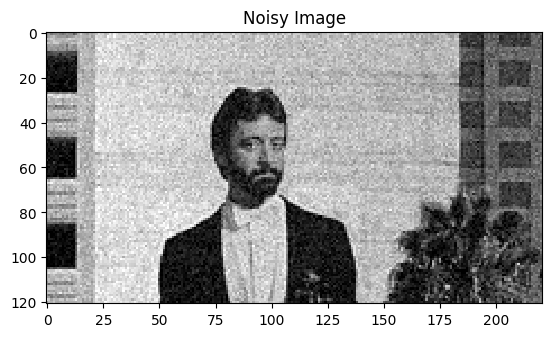

PyObject Text(0.5,1,'Noisy Image')

In [4]:

    
    gt=PyPlot.imread("la.png")
    gt=gt*255; ## normalise in the range of 0 to 255
    gt=convert(Array{Float64,2},gt);  # convert each element to float64
    
    Y=PyPlot.imread("la-noisy.png")
    Y=Y*255; #normalise
    Y=convert(Array{Float64,2},Y);
    
    X=deepcopy(Y)  #Y is the noisy image and X is the current prediction of noisy image
    sigmaN=15.0;  # fixed
    theta_init=[10,0.1];  # any random value of sigma and alpha
    
    
   
    display("Noisy Image PSNR ")
    display(psnr(gt,Y))
    figure();
    PyPlot.imshow(Y,"gray");
    title("Noisy Image")
    
   

"Learnt sigma"

42.67208225893354

"Learnt alpha"

423.11207933958974

"PSNR of denoised image"

29.226851873182298

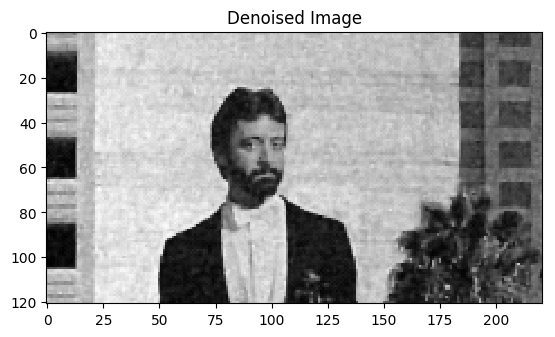

PyObject Text(0.5,1,'Denoised Image')

In [5]:
      
    ## given a ground truth image and noisy image we need to find the optimal theta that gives best denosing
    minTheta=find_optimal_params(gt, X, Y, sigmaN, theta_init)  ## 
        
    display("Learnt sigma")
    display(minTheta[1])
    display("Learnt alpha")
    display(minTheta[2])
    
    DN,dsigma,dalpha=prediction(Y, Y, sigmaN,minTheta[1],minTheta[2]);
    display("PSNR of denoised image")
    display(psnr(gt,DN))
    figure();
    PyPlot.imshow(DN,"gray");
    title("Denoised Image")
    
    

"PSNR after Iteration count = 1"

29.226851873182298

"PSNR after Iteration count = 2"

29.945332943646534

"PSNR after Iteration count = 3"

30.106938703689202

"PSNR after Iteration count = 4"

30.159919971786884

"PSNR after Iteration count = 5"

30.180280388645627

"PSNR after Iteration count = 6"

30.190002903984357

"PSNR after Iteration count = 7"

30.195185280384017

"PSNR after Iteration count = 8"

30.198195254080748

"PSNR after Iteration count = 9"

30.200145347922508

"PSNR after Iteration count = 10"

30.20142177014716

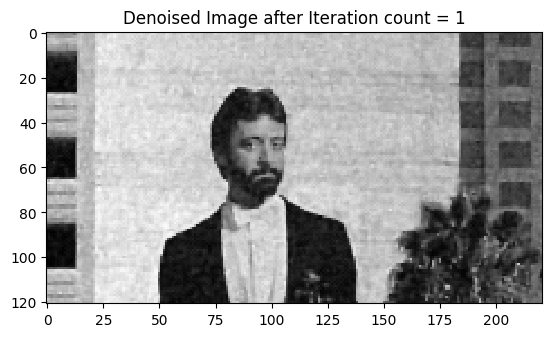

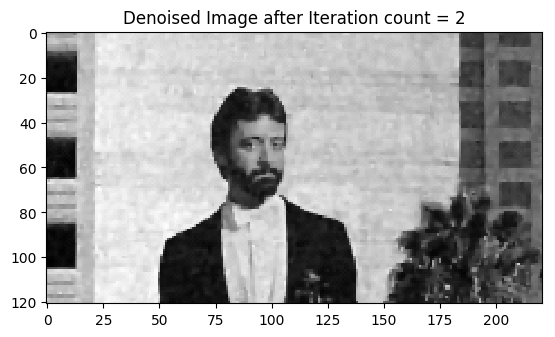

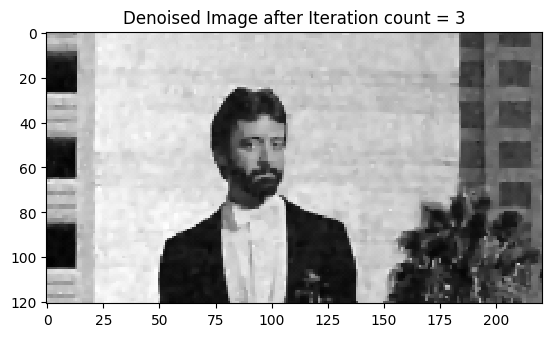

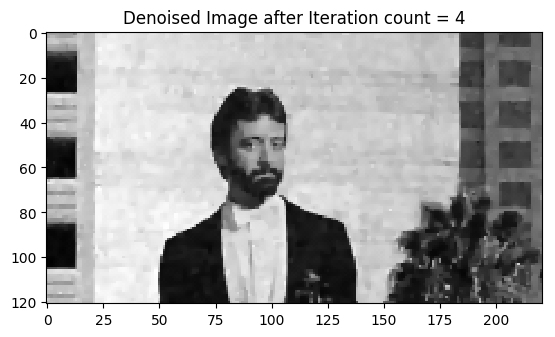

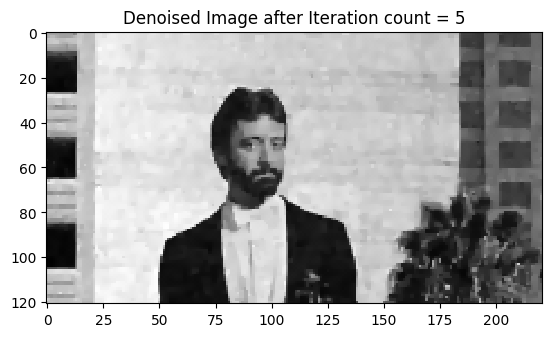

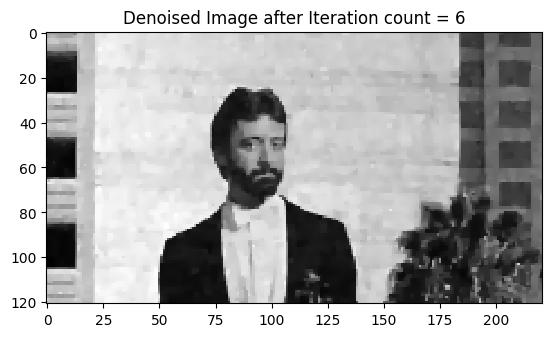

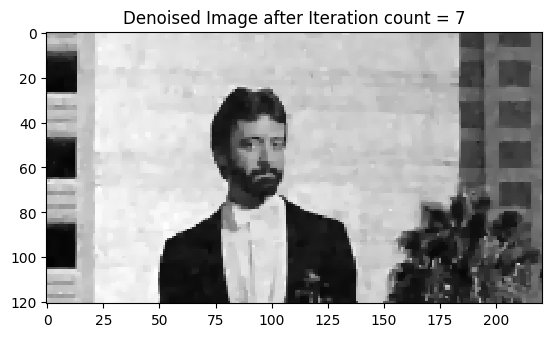

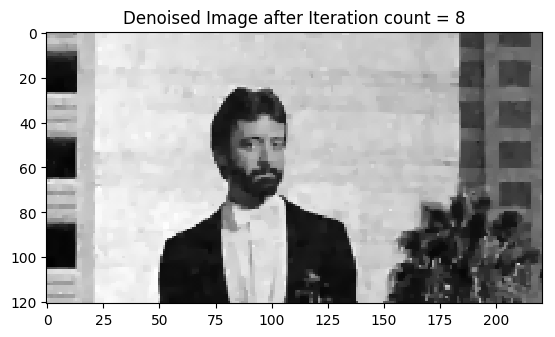

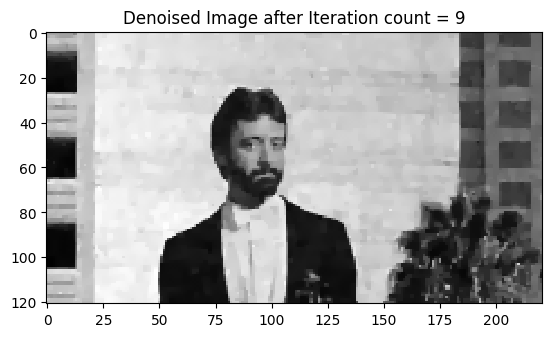

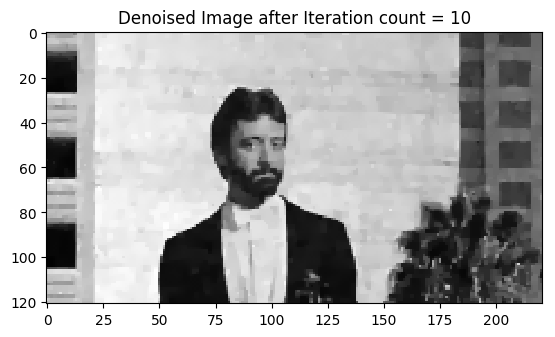

In [6]:
for t=1:10
        minTheta=find_optimal_params(gt, Y, Y, sigmaN, theta_init) # provide with predicted Y and theta_init for next iteration
        Y,dsigma,dalpha=prediction(Y, Y, sigmaN,minTheta[1],minTheta[2]);
        figure();
        PyPlot.imshow(Y,"gray");
        title("Denoised Image after Iteration count = $t")
        display("PSNR after Iteration count = $t")
        display(psnr(gt,Y))
        theta_init=minTheta  ## initilise the theta with last predicted one
    end
        
